In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import rasterio as rio
from scipy.interpolate import griddata
import pyproj
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

path_root = os.path.join(os.environ['PROJDIR'], 'E3SM', 'inputdata', 'lnd', 'clm2', 'PTCLM', 
                         'ERW_CONUS_off')

# copy from the non-ERW file
os.system(f"cp {path_root}/surfdata.nc {path_root}/surfdata_orig.nc")

0

In [2]:
# Read soil grids pH and CEC_TOT
path_soilgrids = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data')

soilgrids_map = {}
for j, (col, newname) in enumerate(zip(
    ['cec_mean.tif', 'phh2o_mean.tif'], 
    ['CEC_TOT', 'SOIL_PH']
)):
    h = rio.open(os.path.join(path_soilgrids, col))

    # google earth engine exported file already in EPSG 4326
    left, bottom, right, top = h.bounds
    crs = h.crs
    rows, cols = np.indices(h.shape)
    src_x, src_y = rio.transform.xy(h.transform, rows, cols)
    lons = np.array(src_x)
    lats = np.array(src_y)

    # conduct reprojection
    lats_target = np.arange(23.25, 54.26, 0.5)
    lons_target = np.arange(234.75, 293.26, 0.5) - 360.
    lons_target, lats_target = np.meshgrid(lons_target, lats_target)
    src_coords = np.array([lons.flatten(), lats.flatten()]).T

    # loop through the layers
    soilgrids_map[newname] = []
    for i in range(1, h.count+1):
        # read data
        data = h.read(i, masked = True)

        # scale CEC from mmol/kg to mmol 100g-1 dry soil
        # scale pHx10 to pH
        data = data / 10.

        src_data_flat = data.flatten()
        data_reproj = griddata(src_coords, src_data_flat, (lons_target, lats_target),
                               method='linear')

        # save transformed data
        soilgrids_map[newname].append(data_reproj)

    h.close()

In [3]:
# Stack and convert to xarray format
soilgrids_top = np.array([0, 5, 15, 30, 60, 100]) # cm
soilgrids_bot = np.array([5, 15, 30, 60, 100, 200])
soilgrids_node = 0.5 * (soilgrids_top + soilgrids_bot) / 100
elm_nodes = np.array([0.0075, 0.0279, 0.0623, 0.1189, 0.2122, 0.3661, 0.6198, 1.0380, 1.7276, 2.8646])

soilgrids_data = {}
encoding = {}
for col in soilgrids_map.keys():
    # Layer mapping: weighted average
    temp = [soilgrids_map[col][0]]
    for node in elm_nodes[1:-2]:
        prev = np.where(soilgrids_node < node)[0][-1]
        next = np.where(soilgrids_node > node)[0][0]
        next_weight = (node - soilgrids_node[prev])
        prev_weight = (soilgrids_node[next] - node)

        # print(node, prev, next, soilgrids_node[prev], soilgrids_node[next])

        temp.append( (soilgrids_map[col][prev]*prev_weight + soilgrids_map[col][next]*next_weight) / (prev_weight + next_weight) )
    temp.extend([soilgrids_map[col][-1], soilgrids_map[col][-1]])

    data = np.stack(temp, axis = 2)
    data = np.moveaxis(data, source=2, destination=0)
    soilgrids_data[col] = xr.DataArray(data, dims = ['nlevsoi','lsmlat','lsmlon']) # no coords in surfdata file
    encoding[col] = {'dtype': np.float32, '_FillValue': 1e20}
soilgrids_data = xr.Dataset(soilgrids_data)

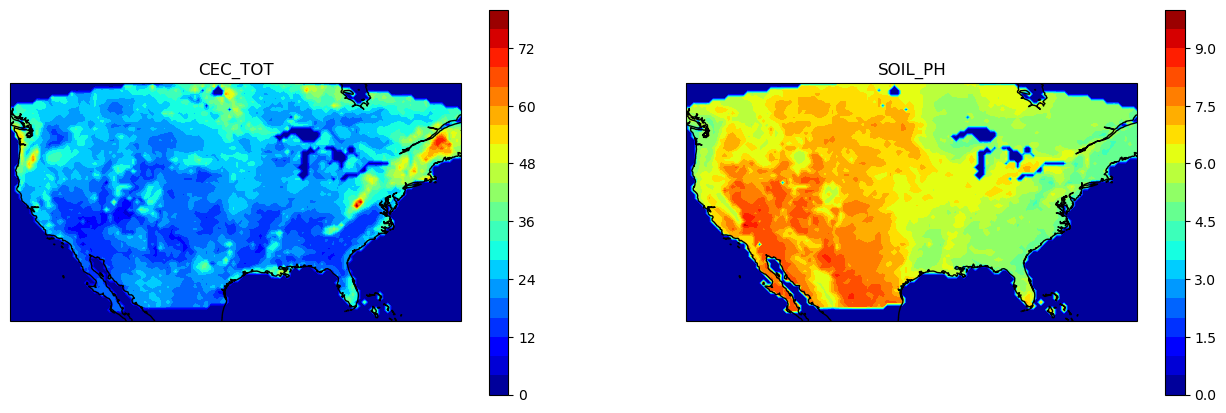

In [4]:
# sanity check
fig, axes = plt.subplots(1, 2, figsize = (16, 5), subplot_kw = {'projection': ccrs.PlateCarree()})
for i, var in enumerate(soilgrids_data.data_vars):
    ax = axes.flat[i]
    ax.coastlines()
    if i == 1:
        levels = np.linspace(0, 10, 21)
    else:
        levels = np.linspace(0, 80, 21)
    cf = ax.contourf(lons_target[0,:], lats_target[:,0], soilgrids_data[var][0, :, :], 
                     cmap = 'jet', levels = levels)
    plt.colorbar(cf, ax = ax)
    ax.set_title(var)

In [5]:
# Read NCSS maps and interpoate to 0.5 degree maps
elm_bot = 100 * np.array([ 0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)
path_ncss = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results')

CEC_maps = {}
for j, (col, newname) in enumerate(zip(
    ['beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al'], 
    ['CEC_ACID', 'CEC_EFF_1', 'CEC_EFF_2', 'CEC_EFF_3', 'CEC_EFF_4', 'CEC_EFF_5']
)):
    CEC_maps[newname] = []
    for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):

        h = rio.open(os.path.join(path_ncss, f'interp_NCSS_layer_{i}_{col}.tif'))

        # read data
        data = h.read(1, masked = True)

        # collect projection info
        left, bottom, right, top = h.bounds
        crs = h.crs
        rows, cols = np.indices(data.shape)
        src_x, src_y = rio.transform.xy(h.transform, rows, cols)
        src_x = np.array(src_x)
        src_y = np.array(src_y)

        # convert X-Y to lat-lon
        in_proj = pyproj.Proj(init="epsg:{}".format(crs.to_epsg()))
        out_proj = pyproj.Proj(init="epsg:4326")
        ## sanity check passed
        # lons, lats = pyproj.transform(in_proj, out_proj, [left, right, left, right], [top, top, bottom, bottom])
        # for lat, lon in zip(lats, lons):
        #    print(lat, lon)
        lons, lats = pyproj.transform(in_proj, out_proj, src_x, src_y)

        # conduct reprojection
        lats_target = np.arange(23.25, 54.26, 0.5)
        lons_target = np.arange(234.75, 293.26, 0.5) - 360.
        lons_target, lats_target = np.meshgrid(lons_target, lats_target)
        src_coords = np.array([lons.flatten(), lats.flatten()]).T
        src_data_flat = data.flatten()
        data_reproj = griddata(src_coords, src_data_flat, (lons_target, lats_target),
                               method='linear')

        h.close()

        # save transformed data
        CEC_maps[newname].append(data_reproj)

/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_1435849/3042209645.py:34: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-f

In [6]:
# Stack and convert to xarray format
CEC_data = {}
encoding = {}
for col in CEC_maps.keys():
    # Layer mapping: 0 => 0:3, 1 => 3:5, 2 => 5, 3 => 6, 4 => 7, 5 => 8:10
    data = np.stack(
        [CEC_maps[col][0], CEC_maps[col][0], CEC_maps[col][0], 
         CEC_maps[col][1], CEC_maps[col][1], CEC_maps[col][2], 
         CEC_maps[col][3], CEC_maps[col][4], 
         CEC_maps[col][5], CEC_maps[col][5]], 
        axis = 2)
    data = np.moveaxis(data, source=2, destination=0)

    # multiply beta with total CEC
    CEC_data[col] = xr.DataArray(data * soilgrids_data['CEC_TOT'].values,
                                 dims = ['nlevsoi','lsmlat','lsmlon']) # no coords in surfdata file
    encoding[col] = {'dtype': np.float32, '_FillValue': 1e20}
CEC_data = xr.Dataset(CEC_data)

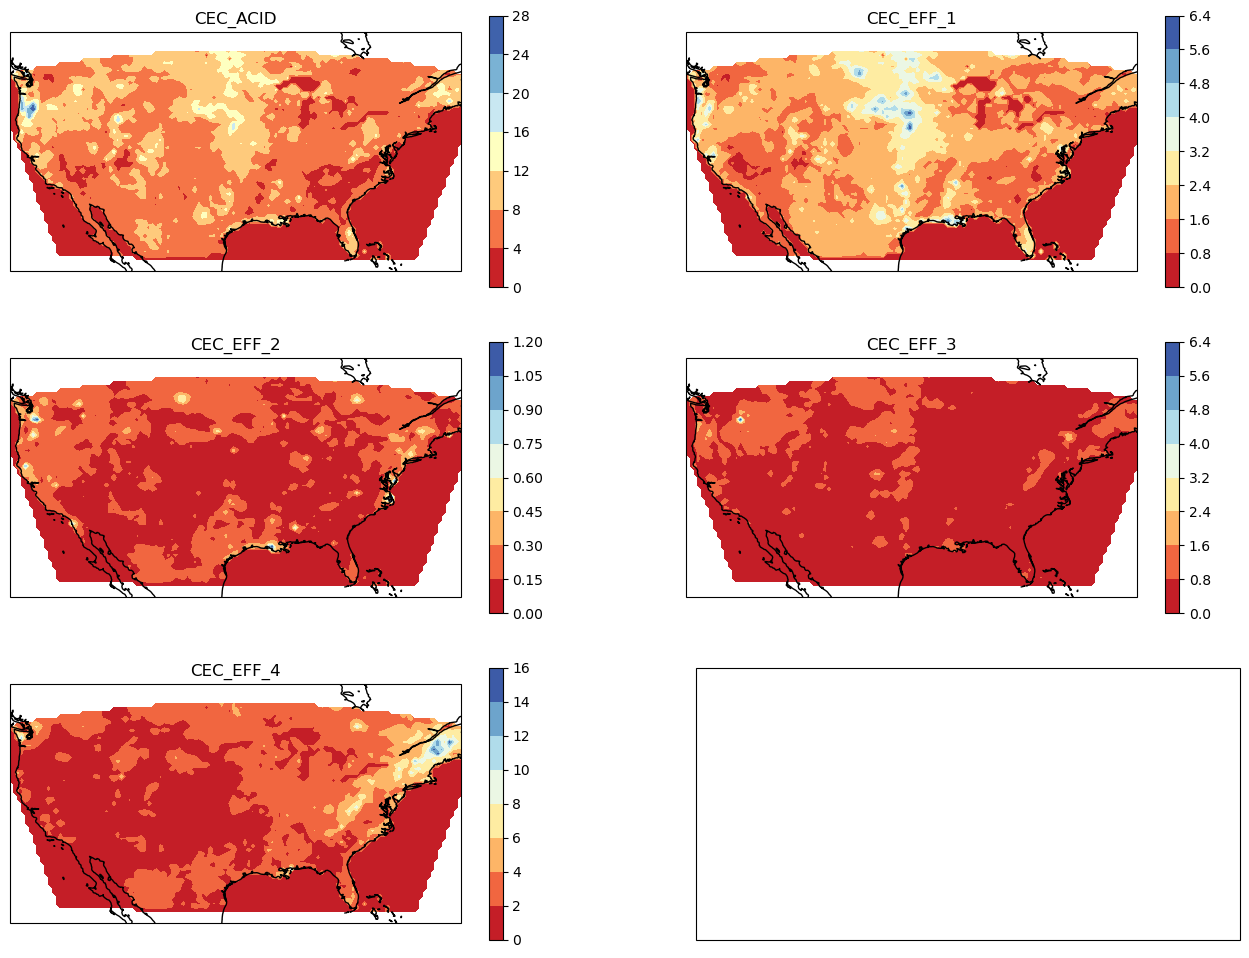

In [7]:
# sanity check
fig, axes = plt.subplots(3, 2, figsize = (16, 12), subplot_kw = {'projection': ccrs.PlateCarree()})
for i, var in enumerate(CEC_data.data_vars):
    ax = axes.flat[i]
    ax.coastlines()
    cf = ax.contourf(lons_target[0,:], lats_target[:,0], CEC_data[var][0, :, :], cmap = 'RdYlBu')
    plt.colorbar(cf, ax = ax)
    ax.set_title(var)

In [ ]:
# 

In [8]:
# put into the NetCDF
hr = xr.open_dataset(os.path.join(path_root, 'surfdata_orig.nc'))
hr.update(CEC_data)
hr.update(soilgrids_data)
hr.to_netcdf(os.path.join(path_root, 'surfdata_erw.nc'), encoding = encoding)
hr.close()